<a href="https://colab.research.google.com/github/anujtrivedi074/jovian-career-website/blob/main/notebook1166ab3469_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How Much Did It Rain? II Predicting hourly rainfall using data from polarimetric radars**

Use the "Run" button to execute the code.
![](https://i.imgur.com/MOctaFy.jpg)

Rainfall is highly variable across space and time, making it notoriously tricky to measure. Rain gauges can be an effective measurement tool for a specific location, but it is impossible to have them everywhere. In order to have widespread coverage, data from weather radars is used to estimate rainfall nationwide. Unfortunately, these predictions never exactly match the measurements taken using rain gauges.
Predicting rainfall accurately and timely is crucial for various applications such as flood management, agriculture, and urban planning. Traditional rainfall estimation methods often rely on rain gauges, which provide point measurements and are limited in their spatial coverage. To overcome this limitation and enhance rainfall prediction, the use of polarimetric radars has gained significant attention in recent years.
Recently, in an effort to improve their rainfall predictors, the U.S. National Weather Service upgraded their radar network to be polarimetric.
These polarimetric radars are able to provide higher quality data than conventional Doppler radars because they transmit radio wave pulses with both horizontal and vertical orientations.Dual pulses make it easier to infer the size and type of precipitation because rain drops become flatter as they increase in size, whereas ice crystals tend to be elongated vertically.

In this competition, you are given snapshots of polarimetric radar values and asked to predict the hourly rain gauge total. A word of caution: many of the gauge values in the training dataset are implausible (gauges may get clogged, for example). More details are on the data page.
The objective of this project is to develop a predictive model for hourly rainfall using data from polarimetric radars. By leveraging machine learning techniques and the rich information provided by polarimetric radar measurements, we aim to improve the accuracy and spatial coverage of rainfall predictions. This will enable better preparedness for extreme weather events, enhanced water resource management, and more effective planning and decision-making in various sectors.

In [18]:
!pip install jovian --upgrade --quiet

In [19]:
import jovian

In [20]:
# Execute this to save new versions of the notebook
jovian.commit(project="How Much Did It Rain? II Predicting hourly rainfall using data from polarimetric radars")

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


# **1. Download the Dataset**
The steps need to do in this section are:

* Install required libraries
* Download data from Kaggle
* View dataset files
* Load training set with Pandas
* Load test set with Pandas

### Install required libraries
Install and import the libraries to download and read the dataset, visualize the data and also to train the ML models.

In [21]:
! pip install opendatasets plotly pandas numpy lightgbm xgboost matplotlib seaborn folium --q

In [22]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import KFold
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import percentileofscore

### Download data from Kaggle

We'll use the [opendatasets](https://github.com/JovianML/opendatasets) library to download the dataset. You'll need to upload your [Kaggle API key](https://github.com/JovianML/opendatasets/blob/master/README.md#kaggle-credentials) (a file called `kaggle.json`) to Colab.

Dataset link: https://www.kaggle.com/competitions/how-much-did-it-rain-ii/data

In [23]:
od.download('https://www.kaggle.com/competitions/how-much-did-it-rain-ii/data')

Skipping, found downloaded files in "./how-much-did-it-rain-ii" (use force=True to force download)


In [24]:
data_dir = './how-much-did-it-rain-ii'

### **View Dataset Files**

Let us look at the size, no. of lines and first few lines of each file.

In [25]:
# Training set
train_data = pd.read_csv("./how-much-did-it-rain-ii/train.zip")

In [26]:
train_data

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13765196,1180945,38,9.000,33.000,19.500,25.500,36.500,33.000,20.500,28.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636
13765197,1180945,42,9.000,33.000,21.000,30.500,37.000,36.500,22.000,33.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636
13765198,1180945,47,9.000,29.500,10.000,26.000,30.500,31.000,16.500,26.000,...,1.052,1.750,NaN,0.750,3.000,13.380,NaN,NaN,13.380,8.636
13765199,1180945,52,9.000,19.000,NaN,15.500,26.500,19.000,NaN,16.500,...,1.052,NaN,NaN,NaN,2.812,NaN,NaN,NaN,NaN,8.636


In [27]:
train_data.columns

Index(['Id', 'minutes_past', 'radardist_km', 'Ref', 'Ref_5x5_10th',
       'Ref_5x5_50th', 'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp', 'Kdp_5x5_10th',
       'Kdp_5x5_50th', 'Kdp_5x5_90th', 'Expected'],
      dtype='object')

In [28]:
train_data.isna().sum()

Id                              0
minutes_past                    0
radardist_km                    0
Ref                       7415826
Ref_5x5_10th              8481213
Ref_5x5_50th              7408719
Ref_5x5_90th              6213920
RefComposite              7048858
RefComposite_5x5_10th     8009528
RefComposite_5x5_50th     7053538
RefComposite_5x5_90th     5935998
RhoHV                     8830285
RhoHV_5x5_10th            9632047
RhoHV_5x5_50th            8828633
RhoHV_5x5_90th            7859617
Zdr                       8830285
Zdr_5x5_10th              9632047
Zdr_5x5_50th              8828633
Zdr_5x5_90th              7859617
Kdp                       9582566
Kdp_5x5_10th             10336419
Kdp_5x5_50th              9577920
Kdp_5x5_90th              8712425
Expected                        0
dtype: int64

In [29]:
def process_data(train_data):
    train_data_mean = train_data.groupby('Id').mean()
    train_data_mean.fillna(0,inplace=True)
    train_data_mean.reset_index(inplace=True)
    return train_data_mean

In [30]:
train_data_mean = process_data(train_data)
train_data_mean.isnull().sum()

Id                       0
minutes_past             0
radardist_km             0
Ref                      0
Ref_5x5_10th             0
Ref_5x5_50th             0
Ref_5x5_90th             0
RefComposite             0
RefComposite_5x5_10th    0
RefComposite_5x5_50th    0
RefComposite_5x5_90th    0
RhoHV                    0
RhoHV_5x5_10th           0
RhoHV_5x5_50th           0
RhoHV_5x5_90th           0
Zdr                      0
Zdr_5x5_10th             0
Zdr_5x5_50th             0
Zdr_5x5_90th             0
Kdp                      0
Kdp_5x5_10th             0
Kdp_5x5_50th             0
Kdp_5x5_90th             0
Expected                 0
dtype: int64

In [31]:
dtypes = {'minutes_past': 'float32',
          'radardist_km': 'float32',
          'Ref': 'float32',
          'Ref_5x5_10th': 'float32',
          'Ref_5x5_50th': 'float32',
          'Ref_5x5_90th': 'float32',
          'RefComposite': 'float32',
          'RefComposite_5x5_10th': 'float32',
          'RefComposite_5x5_50th': 'float32',
          'RefComposite_5x5_90th': 'float32',
          'RhoHV': 'float32',
          'RhoHV_5x5_10th': 'float32',
          'RhoHV_5x5_50th': 'float32',
          'RhoHV_5x5_90th': 'float32',
          'Zdr': 'float32',
          'Zdr_5x5_10th': 'float32',
          'Zdr_5x5_50th': 'float32',
          'Zdr_5x5_90th': 'float32',
          'Kdp': 'float32',
          'Kdp_5x5_10th': 'float32',
          'Kdp_5x5_50th': 'float32',
          'Kdp_5x5_90th': 'float32',
          'Expected': 'float32'}

In [32]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [33]:
train_data_mean[["minutes_past", "radardist_km", "Expected"]].describe()

,minutes_past,radardist_km,Expected
count,1180945.000,1180945.000,1180945.000
mean,29.515,11.183,132.245
std,1.718,4.224,603.080
min,1.000,0.000,0.010
25%,28.667,9.000,0.254
50%,29.538,12.000,1.016
75%,30.412,14.000,3.810
max,58.000,21.000,33017.730


## **Calculating Correlation matrix**

In [34]:
corr_mat = train_data_mean.corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id,1.000000,0.002375,0.002958,-0.006771,-0.008363,-0.007825,-0.005892,-0.007080,-0.009617,-0.008166,-0.006109,0.003722,-0.000284,0.002515,0.005326,0.002638,-0.009622,-0.008014,0.007448,0.002878,-0.005197,-0.006567,0.009887,-0.001917
minutes_past,0.002375,1.000000,-0.014238,0.020703,0.020204,0.021036,0.020391,0.021189,0.020970,0.021351,0.020461,0.021173,0.022676,0.021886,0.018913,0.008010,-0.008857,0.009291,0.015600,-0.000500,-0.015614,-0.004665,0.012164,-0.003579
radardist_km,0.002958,-0.014238,1.000000,-0.340769,-0.350270,-0.350836,-0.354470,-0.390624,-0.410689,-0.400460,-0.391326,-0.515445,-0.487149,-0.512973,-0.541701,-0.301517,0.219441,-0.318327,-0.504679,-0.009012,0.233450,0.038656,-0.211445,0.113142
Ref,-0.006771,0.020703,-0.340769,1.000000,0.926889,0.981243,0.959964,0.985410,0.927469,0.971742,0.949775,0.596912,0.604919,0.610252,0.585231,0.152339,-0.255143,0.171787,0.349323,0.003063,-0.450549,-0.098873,0.418131,-0.201631
Ref_5x5_10th,-0.008363,0.020204,-0.350270,0.926889,1.000000,0.947056,0.896178,0.918689,0.979000,0.935615,0.888605,0.591409,0.624580,0.609977,0.565835,0.144512,-0.240732,0.188481,0.329942,0.002763,-0.458218,-0.072095,0.414434,-0.177406
Ref_5x5_50th,-0.007825,0.021036,-0.350836,0.981243,0.947056,1.000000,0.954097,0.972320,0.948286,0.987057,0.944756,0.603318,0.619033,0.619175,0.586571,0.151557,-0.256431,0.181452,0.348377,0.002365,-0.458840,-0.093531,0.422099,-0.197015
Ref_5x5_90th,-0.005892,0.020391,-0.354470,0.959964,0.896178,0.954097,1.000000,0.960585,0.904518,0.955500,0.989373,0.607703,0.606644,0.619249,0.604012,0.163526,-0.274256,0.178712,0.373651,0.002410,-0.453044,-0.107486,0.422121,-0.213795
RefComposite,-0.007080,0.021189,-0.390624,0.985410,0.918689,0.972320,0.960585,1.000000,0.937417,0.983534,0.963642,0.616446,0.624131,0.630364,0.605266,0.169881,-0.266814,0.195107,0.376758,0.000782,-0.456056,-0.101376,0.418328,-0.204606
RefComposite_5x5_10th,-0.009617,0.020970,-0.410689,0.927469,0.979000,0.948286,0.904518,0.937417,1.000000,0.955249,0.907383,0.614440,0.646670,0.633910,0.589585,0.164909,-0.255403,0.217608,0.363022,-0.001013,-0.465328,-0.077710,0.414568,-0.182924
RefComposite_5x5_50th,-0.008166,0.021351,-0.400460,0.971742,0.935615,0.987057,0.955500,0.983534,0.955249,1.000000,0.957832,0.621573,0.636051,0.637932,0.605833,0.169303,-0.269366,0.203678,0.377009,-0.000054,-0.462844,-0.097063,0.420600,-0.200469


4 = -0.201631,
6 = 	-0.197015,
7 = -0.213795,
8 = 	-0.204606,
10 = -0.200469,
11 = -0.215364

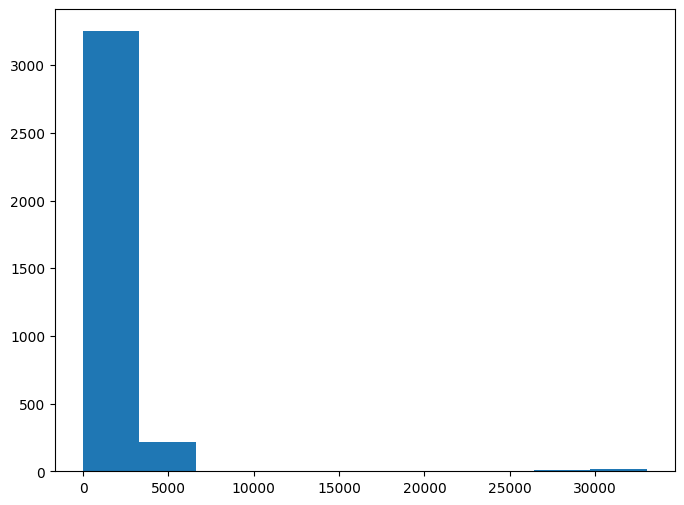

In [35]:
plt.figure(figsize=(8,6))
plt.hist(train_data_mean["Expected"].unique())
plt.show()

- The x-axis represents the unique values in the "Expected" column, while the y-axis represents the frequency (number of occurrences) of each unique value.

- The histogram shows a right-skewed distribution, as the tail of the distribution extends towards higher values on the x-axis.

- The majority of the unique values appear to be clustered towards the left side of the histogram, suggesting that there are many instances of low "Expected" values.

- There are relatively fewer occurrences of higher "Expected" values, as indicated by the smaller bar heights on the right side of the histogram.

- The histogram may have some outliers or extreme values on the right side, which could be causing the right-skewed shape.


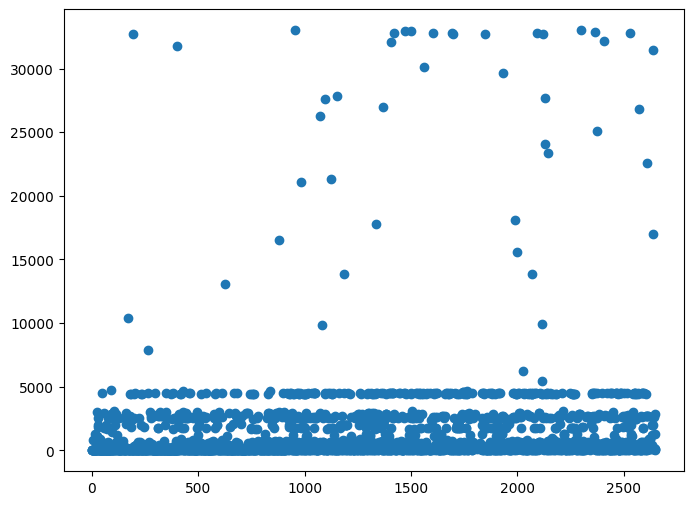

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(train_data["Expected"].unique())), train_data["Expected"].unique())

## **Handling the Outliers**

In [37]:
train_data_mean.Expected.mean()

132.24529013519393

In [38]:
print(stats.percentileofscore(train_data_mean["Expected"], 132))

91.77099695582775


In [39]:
train_data_mean.drop(train_data_mean[train_data_mean["Expected"] >= 106].index, inplace=True)
train_data_mean

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,29.833,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.254
1,2,29.083,2.000,16.625,13.667,17.375,21.333,22.667,20.375,22.917,...,1.000,0.380,0.120,0.417,0.781,-0.288,-1.449,-0.319,1.117,1.016
2,3,30.750,10.000,0.000,0.000,0.000,8.500,0.000,0.000,0.000,...,0.802,0.000,0.000,0.000,2.062,0.000,0.000,0.000,0.000,26.162
3,4,28.154,9.000,26.600,20.071,25.800,30.269,26.667,21.091,25.115,...,1.016,-1.125,0.000,0.500,1.516,7.030,0.000,0.000,6.330,4.064
5,6,29.833,13.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180937,1180938,28.364,10.000,19.000,0.000,19.000,19.167,23.000,14.000,23.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.508
1180941,1180942,28.462,9.000,15.667,13.000,15.889,19.950,17.333,14.000,15.900,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.524
1180942,1180943,26.500,14.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.254
1180943,1180944,30.765,11.000,26.667,24.375,29.083,33.906,29.167,26.000,28.071,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.556


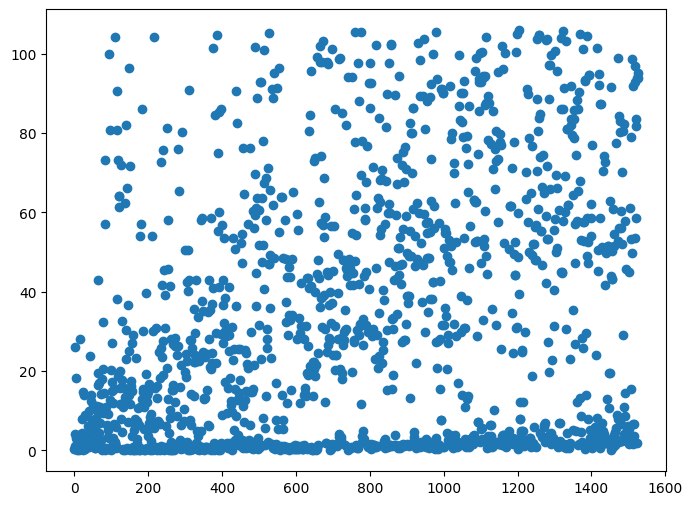

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(train_data_mean["Expected"].unique())), train_data_mean["Expected"].unique())

Text(0.5, 1.0, 'radardist_km')

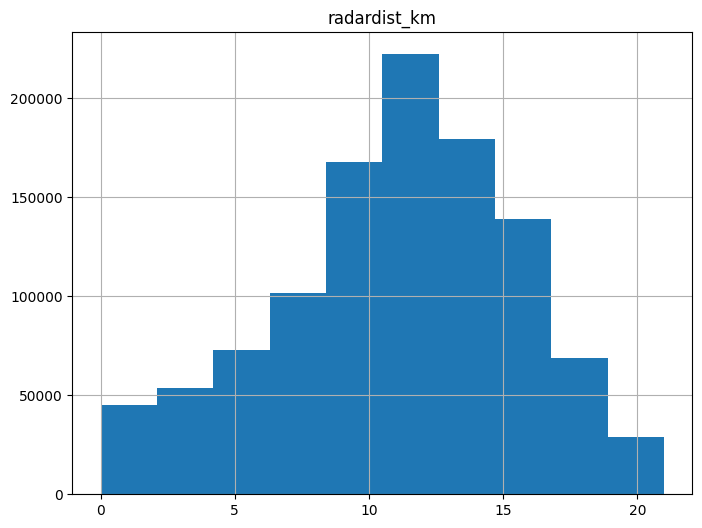

In [41]:
plt.figure(figsize=(8, 6))
train_data_mean["radardist_km"].hist()
plt.title("radardist_km")

Text(0.5, 1.0, 'Ref')

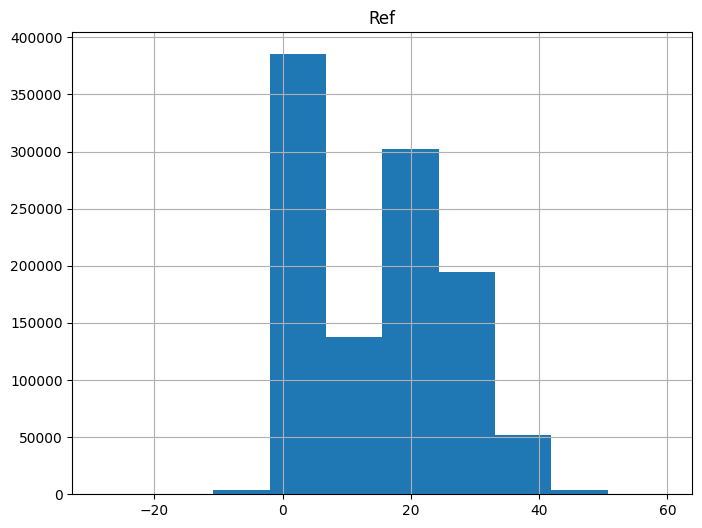

In [42]:
plt.figure(figsize=(8, 6))
train_data_mean["Ref"].hist()
plt.title("Ref")

Text(0.5, 1.0, 'RefComposite')

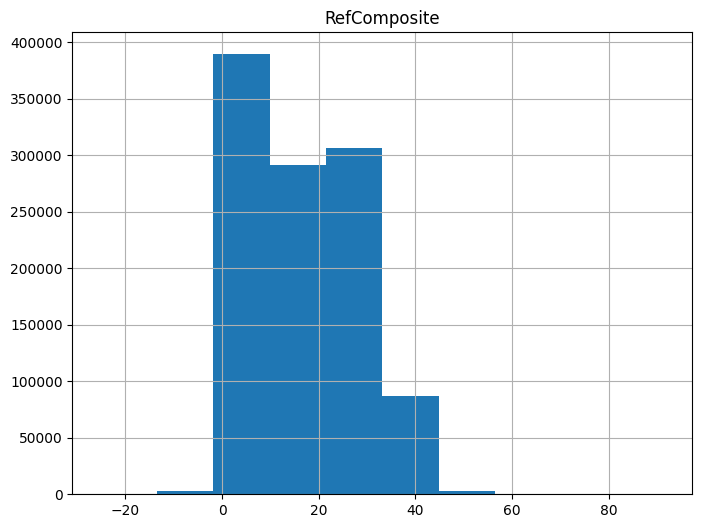

In [43]:
plt.figure(figsize=(8, 6))
train_data_mean["RefComposite"].hist()
plt.title("RefComposite")

Text(0.5, 1.0, 'RhoHV')

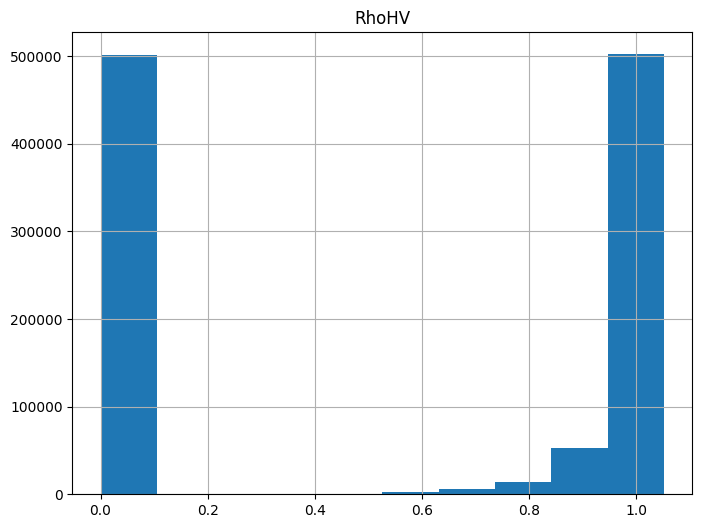

In [44]:
plt.figure(figsize=(8, 6))
train_data_mean["RhoHV"].hist()
plt.title("RhoHV")

Text(0.5, 1.0, 'Zdr')

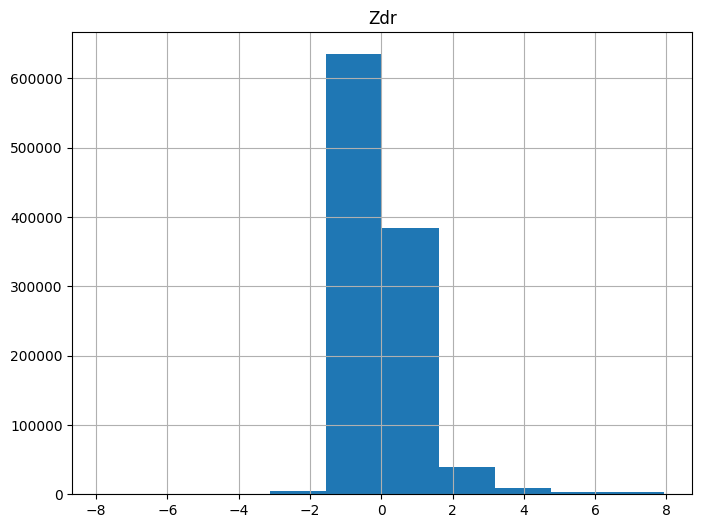

In [45]:
plt.figure(figsize=(8, 6))
train_data_mean["Zdr"].hist()
plt.title("Zdr")

Text(0.5, 1.0, 'Kdp')

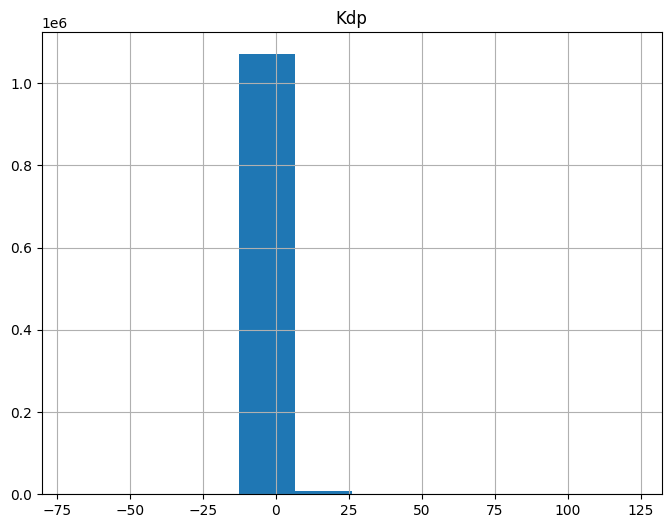

In [46]:
plt.figure(figsize=(8, 6))
train_data_mean["Kdp"].hist()
plt.title("Kdp")

Text(0.5, 1.0, 'Unique Expected')

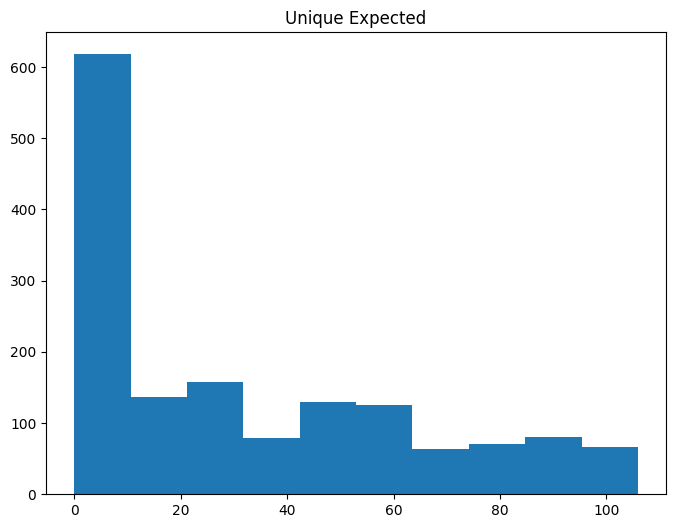

In [47]:
plt.figure(figsize=(8, 6))
plt.hist(train_data_mean["Expected"].unique())
plt.title("Unique Expected")

## **3. Prepare Dataset for Training**

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

### Split Training & Validation Set

We'll set aside 25% of the training data as the validation set, to evaluate the models we train on previously unseen data.

Since the test set and training set have the same date ranges, we can pick a random 25% fraction

In [32]:
train_data_sample = train_data_mean.sample(n=1000000)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train_df, val_df = train_test_split(train_data_sample, test_size=0.25, random_state=42)

In [35]:
len(train_df), len(val_df)

(750000, 250000)

In [36]:
train_data_sample.columns

Index(['Id', 'minutes_past', 'radardist_km', 'Ref', 'Ref_5x5_10th',
       'Ref_5x5_50th', 'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp', 'Kdp_5x5_10th',
       'Kdp_5x5_50th', 'Kdp_5x5_90th', 'Expected'],
      dtype='object')

In [37]:
input_cols = ['minutes_past', 'radardist_km', 'Ref', 'Ref_5x5_10th',
       'Ref_5x5_50th', 'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp', 'Kdp_5x5_10th',
       'Kdp_5x5_50th', 'Kdp_5x5_90th']

In [38]:
target_col = 'Expected'

#### **Training**

In [39]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

In [40]:
scaler = StandardScaler()

In [41]:
scaler.fit_transform(train_inputs)

array([[ 9.37880002e-01, -8.39168668e-03,  1.16205873e+00, ...,
         6.50090198e-01,  2.75131823e-01, -6.62884428e-01],
       [ 1.40133895e+00,  9.26025210e-01,  6.03686705e-01, ...,
        -8.51280537e+00, -3.34732218e+00, -8.50865654e-02],
       [ 1.12583835e+00, -2.41995911e-01,  5.91521737e-01, ...,
        -5.51389267e-01, -6.30582720e-02,  1.65982431e+00],
       ...,
       [ 2.89037476e-01,  2.25212537e-01,  5.76112777e-01, ...,
        -1.37905074e+00,  3.81179188e-01,  1.74404790e+00],
       [ 7.30868339e-01, -2.41995911e-01,  1.61013505e+00, ...,
        -9.88371664e-01,  4.05270613e-01,  7.90836574e-01],
       [ 3.98582318e-01,  6.92420986e-01, -1.17483161e+00, ...,
         6.50090198e-01,  2.75131823e-01, -6.62884428e-01]])

#### Validation

In [42]:
val_inputs = val_df[input_cols]

In [43]:
scaler.fit_transform(val_inputs)

array([[-0.69148362, -2.3435565 , -0.16461244, ..., -3.42786653,
        -0.99604701,  0.54601596],
       [ 1.38315097, -1.40955533,  0.92754064, ...,  0.04674544,
         0.2153283 ,  0.03347857],
       [-2.41124651, -2.11005621, -1.38154724, ...,  0.65047036,
         0.27569955, -0.66361479],
       ...,
       [ 3.72296442,  0.69194729, -1.1749688 , ...,  0.65047036,
         0.27569955, -0.66361479],
       [ 0.35129324,  0.458447  ,  1.31636717, ..., -0.3737189 ,
        -0.37167478,  0.95095615],
       [ 0.79169813, -0.00855358, -1.1749688 , ...,  0.65047036,
         0.27569955, -0.66361479]])

In [44]:
val_targets = val_df[target_col]

#### Test

In [45]:
test = pd.read_csv("./how-much-did-it-rain-ii/test.zip")
test_df = process_data(test)
test_df

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th
0,1,29.824,8.000,10.500,0.000,8.278,13.462,11.375,0.000,8.667,...,0.990,1.044,-0.547,-1.750,0.062,2.598,-1.523,0.000,-1.290,2.602
1,2,28.938,15.000,0.000,0.000,0.000,13.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,3,28.700,11.000,23.722,17.125,24.111,34.700,25.056,16.400,25.222,...,0.955,0.981,0.419,-0.562,0.456,1.825,0.220,-4.359,0.170,5.383
3,4,28.727,9.000,30.812,28.643,29.812,35.625,32.000,28.944,32.667,...,0.971,0.982,0.100,-0.537,0.177,1.241,0.912,-2.890,-0.140,5.563
4,5,28.333,17.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717620,717621,28.400,6.000,14.500,9.000,12.750,16.500,12.800,7.333,8.714,...,0.000,1.023,0.000,0.000,0.000,0.750,0.000,0.000,0.000,-0.935
717621,717622,29.286,15.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
717622,717623,30.308,9.000,21.833,19.056,22.917,31.192,26.000,22.318,24.577,...,0.968,0.994,0.168,-1.188,0.168,1.750,-0.083,-4.717,-0.188,4.842
717623,717624,32.000,11.000,38.000,0.000,37.000,42.833,38.000,0.000,37.500,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [46]:
test_inputs = test_df[input_cols]

## **Data Modeling - preparation**

 - Performance measure (score) and error (loss).
  - All models will be evaluated using the Coefficient of Determination, denoted R^2, pronounced "R squared". It is the proportion of the variation in the dependent variable that is predictable from the independent variable(s).
  - The loss is the calculated value of the Root Mean Squared Error (RMSE), a measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed.

#### Create a Baseline Model.
 - before we begin to use any real models, we will prepare a base line model. It works by simply returning the mean price value of the dataset when asked for a prediction
 - for convenience, we'll define a wrapper function that gets the RMSE between the target prices and predicted ones from whatever model we use to get those predictions.

## 4. Train Hardcoded & Baseline Models

- Hardcoded model: always predict average fare
- Baseline model: Linear regression

For evaluation the dataset uses RMSE error:
https://www.kaggle.com/competitions/how-much-did-it-rain-ii/overview/evaluation

### Train & Evaluate Hardcoded Model

Let's create a simple model that always predicts the average.

In [47]:
import numpy as np

In [48]:
class MeanRegressor():
    def fit(self, inputs, targets):
        self.mean = targets.mean()

    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

In [49]:
mean_model = MeanRegressor()

In [50]:
mean_model.fit(train_inputs, train_targets)

In [51]:
mean_model.mean

3.633769184085543

In [52]:
train_preds = mean_model.predict(train_inputs)

In [53]:
train_preds

array([3.63376918, 3.63376918, 3.63376918, ..., 3.63376918, 3.63376918,
       3.63376918])

In [54]:
val_preds = mean_model.predict(val_inputs)

In [55]:
val_preds

array([3.63376918, 3.63376918, 3.63376918, ..., 3.63376918, 3.63376918,
       3.63376918])

In [56]:
from sklearn.metrics import mean_squared_error

In [57]:
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)

In [58]:
train_rmse

9.939885972392721

In [59]:
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)

In [60]:
val_rmse

9.86067304821072

### Train & Evaluate Baseline Model

We'll traina linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [61]:
linreg_model = LinearRegression()

In [62]:
linreg_model.fit(train_inputs, train_targets)

LinearRegression()

In [63]:
train_preds = linreg_model.predict(train_inputs)
train_preds

array([5.90748782, 3.61136701, 3.38336171, ..., 2.78013195, 4.80551503,
       3.36009734])

In [64]:
val_preds = linreg_model.predict(val_inputs)
val_preds

array([2.03829594, 3.67754562, 0.23749058, ..., 3.29327633, 4.35749025,
       3.48899722])

In [65]:
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
train_rmse

9.87737047726421

In [66]:
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
val_rmse

9.796658055283785

The linear regression model is off by $9.898, which isn't much better than simply predicting the average.

This is mainly because the training data (geocoordinates) is not in a format that's useful for the model, and we're not using one of the most important columns: pickup date & time.

However, now we have a baseline that our other models should ideally beat.

In [67]:
test_preds = linreg_model.predict(test_inputs)

## 5. Make Predictions and Submit to Kaggle

- Make predictions for test set
- Generate submissions CSV
- Submit to Kaggle
- Record in experiment tracking sheet

In [68]:
submission_df = pd.read_csv(data_dir+'/sample_solution.csv.zip')

In [69]:
submission_df

,Id,Expected
0,1,0.086
1,2,0.000
2,3,1.594
3,4,6.913
4,5,0.000
...,...,...
717620,717621,0.064
717621,717622,0.000
717622,717623,1.090
717623,717624,1.297


In [70]:
def generate_submission(test_preds, fname):
    sub_df = pd.read_csv(data_dir+'/sample_solution.csv.zip')
    sub_df['Expected'] = test_preds
    sub_df.to_csv(fname, index=None)

In [71]:
generate_submission(test_preds, 'linreg_submission.csv')

## 7. Train & Evaluate Different Models

We'll train each of the following & submit predictions to Kaggle:

- Linear Regression
- Random Forests
- Gradient Boosting

Exercise: Train Ridge, SVM, KNN, Decision Tree models

In [72]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_mae = mean_absolute_error(train_targets, train_preds)
    val_preds = model.predict(val_inputs)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_mae = mean_absolute_error(val_targets, val_preds)
    print(f'train RMSE: ',train_rmse)
    print(f'train MAE: ',train_mae)
    print(f'val RMSE: ',val_rmse)
    print(f'val MAE: ',val_mae)
    return  train_preds, val_preds

In [73]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data_dir+'/sample_solution.csv.zip')
    sub_df['Expected'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

### Ridge Regression

In [74]:
from sklearn.linear_model import Ridge

In [75]:
model1 = Ridge(random_state=42)

In [76]:
%%time
model1.fit(train_inputs, train_targets)

CPU times: user 130 ms, sys: 30.1 ms, total: 160 ms
Wall time: 148 ms


Ridge(random_state=42)

In [77]:
evaluate(model1)

train RMSE:  9.877370477269269
train MAE:  4.240685412975753
val RMSE:  9.796658072964675
val MAE:  4.221099914690893


(array([5.90747868, 3.61136233, 3.38336079, ..., 2.78012836, 4.80551537,
        3.36009569]),
 array([2.03829098, 3.67754651, 0.23748848, ..., 3.29327477, 4.35749194,
        3.48899398]))

In [78]:
predict_and_submit(model1, 'ridge_submission.csv')

,Id,Expected
0,1,1.664
1,2,3.619
2,3,3.920
3,4,5.024
4,5,3.246
...,...,...
717620,717621,4.284
717621,717622,3.325
717622,717623,3.714
717623,717624,4.914


### **Random Forest**

In [79]:
from sklearn.ensemble import RandomForestRegressor

In [80]:
model2 = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=50)

In [81]:
%%time
model2.fit(train_inputs, train_targets)

CPU times: user 6min 57s, sys: 633 ms, total: 6min 58s
Wall time: 3min 54s


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [82]:
evaluate(model2)

train RMSE:  9.44526364963083
train MAE:  3.9289890258641806
val RMSE:  9.466015188152586
val MAE:  3.9469537584546943


(array([4.64945393, 2.69902945, 2.63542066, ..., 2.40160411, 4.61375348,
        2.14652989]),
 array([1.44181994, 3.22494942, 1.16688411, ..., 2.17823413, 6.64071722,
        5.33533193]))

### Feature Importance

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [83]:
predict_and_submit(model2, 'rf_submission.csv')

,Id,Expected
0,1,1.946
1,2,2.340
2,3,4.206
3,4,4.397
4,5,3.092
...,...,...
717620,717621,1.971
717621,717622,2.062
717622,717623,2.803
717623,717624,6.434


### **DecisionTreeRegressor**

In [84]:
%%time
model3 = DecisionTreeRegressor()
model3.fit(train_inputs, train_targets)

CPU times: user 27.4 s, sys: 26 ms, total: 27.4 s
Wall time: 27.4 s


DecisionTreeRegressor()

In [85]:
evaluate(model3)

train RMSE:  6.349852512160893
train MAE:  1.4788489127898088
val RMSE:  10.076088497510856
val MAE:  3.4899268423056564


(array([2.7940013 , 3.0480015 , 0.25400013, ..., 2.7940013 , 3.810002  ,
        7.30642978]),
 array([ 0.50800025,  0.7620004 ,  0.25400013, ...,  0.25400013,
        12.827007  ,  7.29851864]))

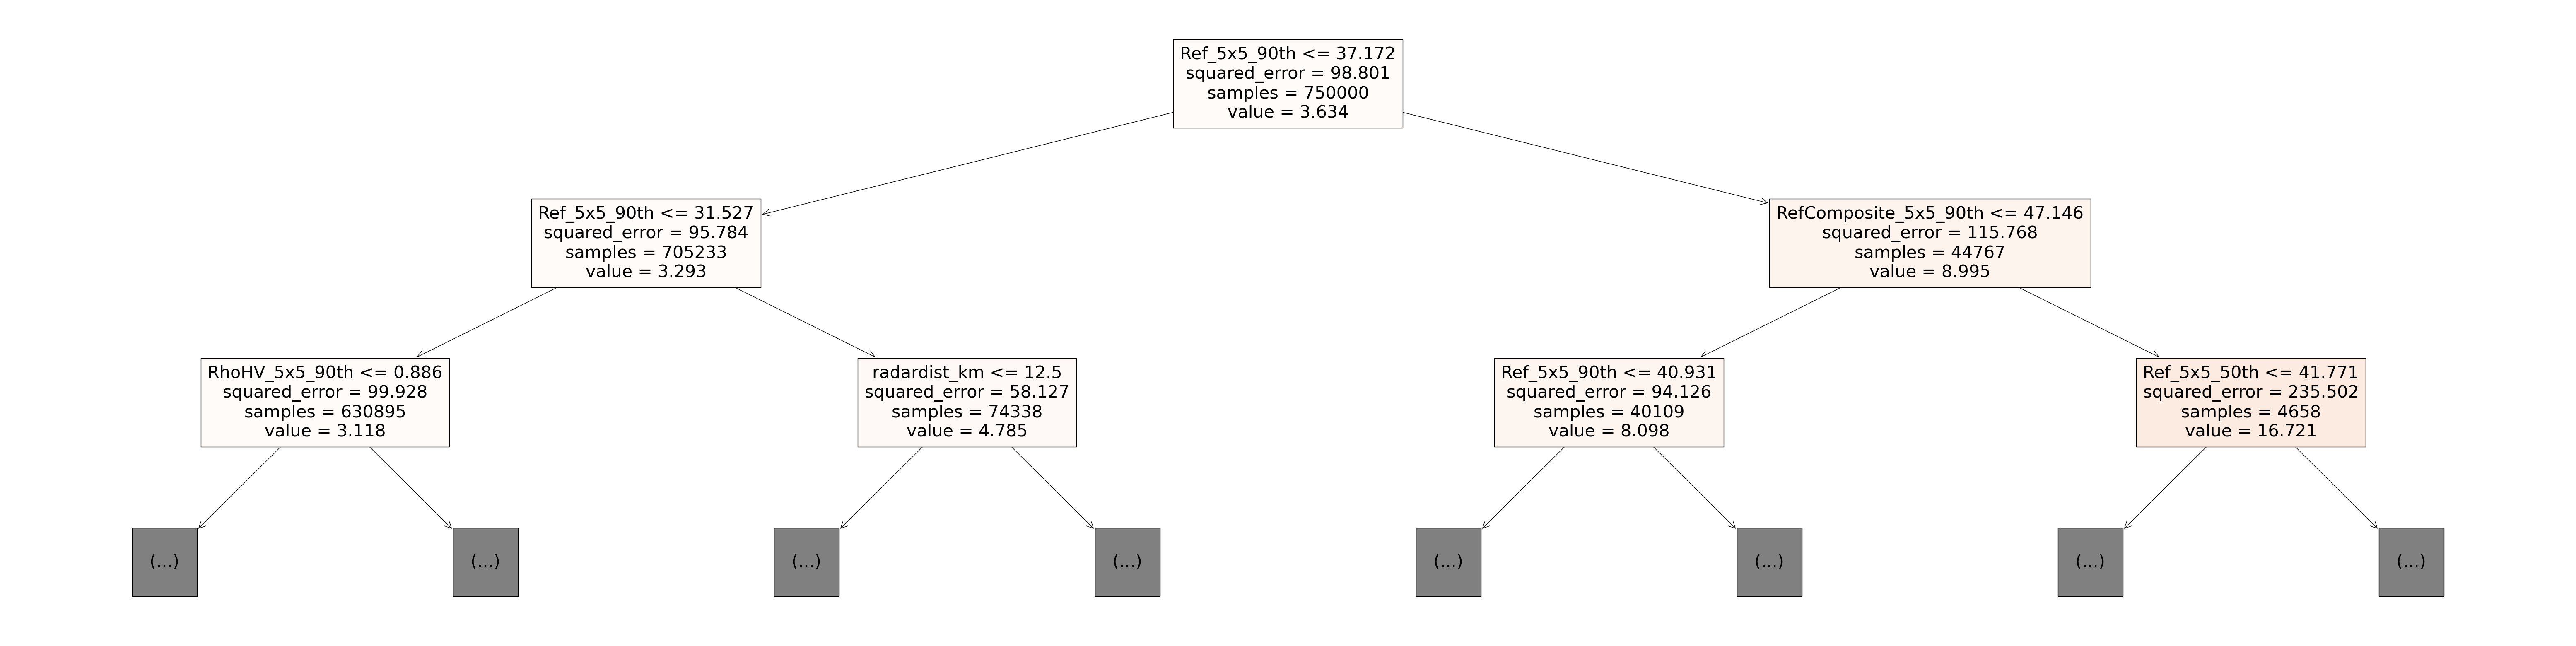

In [86]:
#Visualizing a Decision Tree
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))

plot_tree(model3, feature_names=train_inputs.columns, max_depth=2, filled=True);

In [87]:
predict_and_submit(model3, 'DecisionTree_submission.csv')

,Id,Expected
0,1,0.254
1,2,2.032
2,3,2.032
3,4,3.683
4,5,1.355
...,...,...
717620,717621,0.254
717621,717622,0.976
717622,717623,0.762
717623,717624,7.620


### **Gradient Boosting**

In [88]:
from xgboost import XGBRegressor

In [89]:
model4 = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')

In [90]:
%%time
model4.fit(train_inputs, train_targets)

CPU times: user 4min 6s, sys: 430 ms, total: 4min 6s
Wall time: 2min 30s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [91]:
evaluate(model4)

train RMSE:  9.32143934911899
train MAE:  3.8636641306519968
val RMSE:  9.405571907731003
val MAE:  3.9091482226643626


(array([5.1574664, 3.850201 , 3.2607596, ..., 2.6200902, 3.9865925,
        3.503551 ], dtype=float32),
 array([1.2137299, 3.1533167, 1.2282877, ..., 1.6546112, 7.903365 ,
        5.565822 ], dtype=float32))

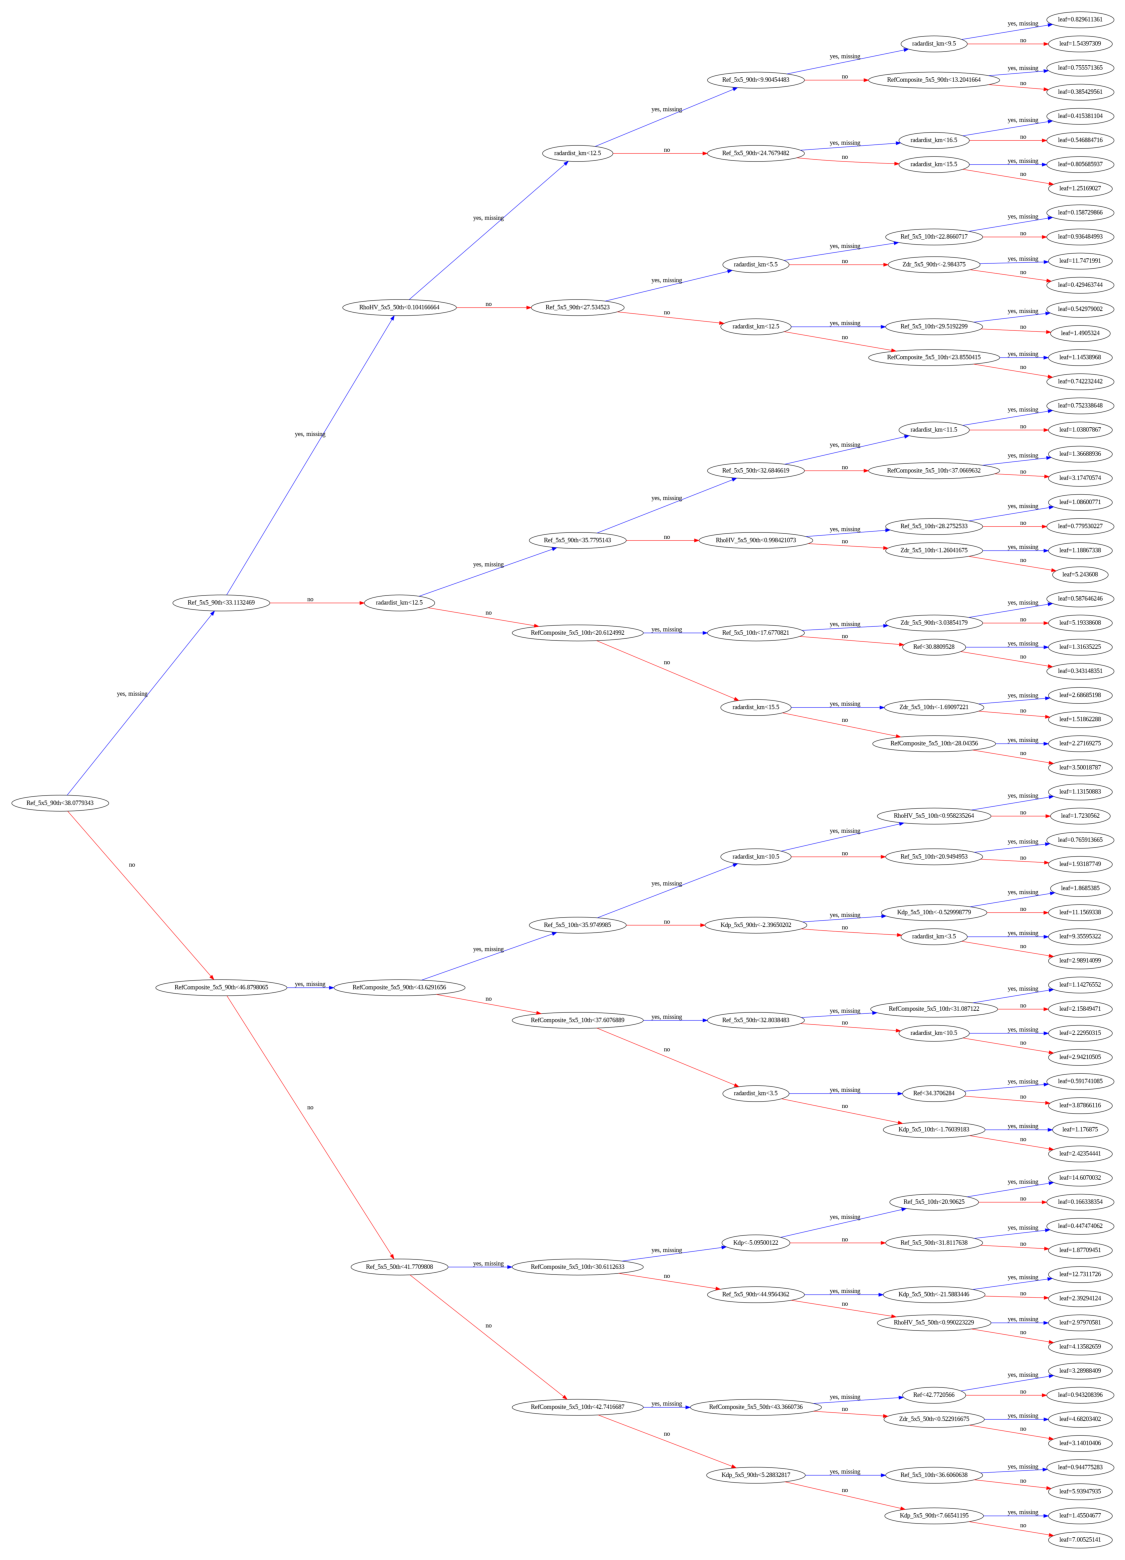

In [92]:
#Visualizing a XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 20,20
plot_tree(model4, rankdir='LR', num_trees=1); # viewing only the 1st tree

In [93]:
predict_and_submit(model4, 'xgb_submission.csv')

,Id,Expected
0,1,1.601
1,2,2.021
2,3,4.121
3,4,3.885
4,5,3.058
...,...,...
717620,717621,1.753
717621,717622,2.238
717622,717623,2.985
717623,717624,6.469


### **8. Tune Hyperparmeters**
https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76

We'll train parameters for the XGBoost model. Here’s a strategy for tuning hyperparameters:

Tune the most important/impactful hyperparameter first e.g. n_estimators

With the best value of the first hyperparameter, tune the next most impactful hyperparameter

And so on, keep training the next most impactful parameters with the best values for previous parameters...

Then, go back to the top and further tune each parameter again for further marginal gains

Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter…

Let's define a helper function for trying different hyperparameters.

In [94]:
import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation MAEE"""
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_mae = mean_absolute_error(model.predict(train_inputs), train_targets)
    val_mae = mean_absolute_error(model.predict(val_inputs), val_targets)
    return train_mae, val_mae

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], []
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_mae, val_mae = test_params(ModelClass, **params)
        train_errors.append(train_mae)
        val_errors.append(val_mae)

    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('MAE')
    plt.legend(['Training', 'Validation'])

In [95]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

### No. of Trees

CPU times: user 33min 5s, sys: 2.2 s, total: 33min 7s
Wall time: 18min 51s


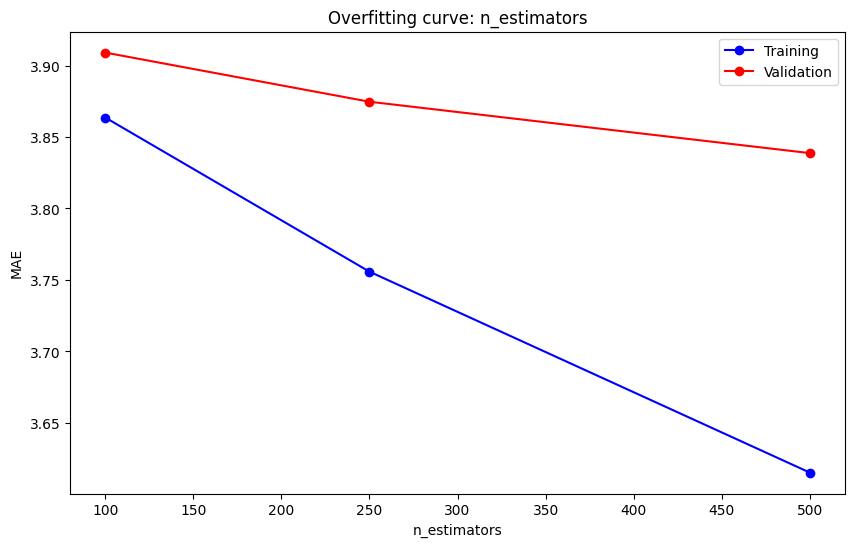

In [96]:
%%time
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 250, 500], **best_params)

Seems like 500 estimators has the lowest validation loss. However, it also takes a long time. Let's stick with 250 for now.

In [97]:
best_params['n_estimators'] = 500

### Max Depth

CPU times: user 44min 21s, sys: 2.61 s, total: 44min 23s
Wall time: 24min 38s


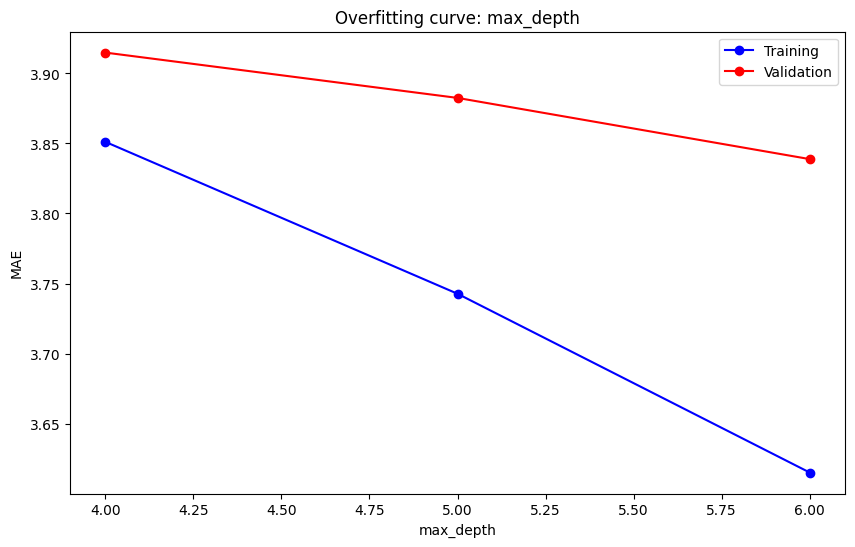

In [98]:
%%time
test_param_and_plot(XGBRegressor, 'max_depth', [ 5, 6, 7], **best_params)

Looks like a max depth of 5 is ideal.

In [99]:
best_params['max_depth'] = 5

### Learning Rate

In [100]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25], **best_params)

KeyboardInterrupt: ignored

Seems like the best learning rate is 0.25.

In [101]:
best_params['learning_rate'] = 0.25

In [102]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=5, learning_rate=0.25)

In [122]:
xgb_model_final2 = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               learning_rate=0.25,)

In [104]:
xgb_model_final3 = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42, max_depth=7,
                               learning_rate=0.25,)

In [106]:
%%time
xgb_model_final3.fit(train_inputs, train_targets)

CPU times: user 4min 29s, sys: 312 ms, total: 4min 29s
Wall time: 2min 29s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [123]:
%%time
xgb_model_final2.fit(train_inputs, train_targets)

CPU times: user 3min 40s, sys: 275 ms, total: 3min 40s
Wall time: 2min 3s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [108]:
%%time
xgb_model_final4.fit(train_inputs, train_targets)

CPU times: user 9min 4s, sys: 605 ms, total: 9min 4s
Wall time: 5min 3s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [124]:
evaluate(xgb_model_final2)

train RMSE:  9.335753301104672
train MAE:  3.873613870083578
val RMSE:  9.4130255328719
val MAE:  3.913037576274297


(array([5.3455486, 3.9949853, 2.568264 , ..., 2.1730776, 3.601342 ,
        2.3529022], dtype=float32),
 array([2.0051773, 3.2673097, 1.1336255, ..., 1.1471196, 7.495828 ,
        5.165073 ], dtype=float32))

In [110]:
evaluate(xgb_model_final3)

train RMSE:  9.205269637640034
train MAE:  3.816892888125254
val RMSE:  9.368406114044156
val MAE:  3.892323796721585


(array([4.4747367, 2.941191 , 2.2949708, ..., 2.373661 , 3.8379765,
        2.5349247], dtype=float32),
 array([1.2803168 , 3.2738755 , 0.90778595, ..., 2.5245776 , 7.073097  ,
        4.892229  ], dtype=float32))

In [111]:
evaluate(xgb_model_final4)

train RMSE:  9.094004474626628
train MAE:  3.7712769519775584
val RMSE:  9.335808364507217
val MAE:  3.877799094858418


(array([5.0554137, 3.976101 , 3.0894372, ..., 2.116706 , 3.163915 ,
        2.9598973], dtype=float32),
 array([1.6743922, 3.0531652, 0.9779918, ..., 1.3228681, 8.046555 ,
        5.022927 ], dtype=float32))

In [112]:
predict_and_submit(xgb_model_final1, 'xgb_tuned_submission1.csv')

NameError: ignored

In [125]:
predict_and_submit(xgb_model_final2, 'xgb_tuned_submission2.csv')

,Id,Expected
0,1,1.736
1,2,1.926
2,3,4.516
3,4,4.672
4,5,3.116
...,...,...
717620,717621,2.088
717621,717622,2.118
717622,717623,2.910
717623,717624,5.840


In [114]:
predict_and_submit(xgb_model_final3, 'xgb_tuned_submission3.csv')

,Id,Expected
0,1,1.525
1,2,1.747
2,3,3.224
3,4,4.216
4,5,2.966
...,...,...
717620,717621,1.783
717621,717622,2.319
717622,717623,2.993
717623,717624,6.332


In [115]:
predict_and_submit(xgb_model_final4, 'xgb_tuned_submission4.csv')

,Id,Expected
0,1,1.474
1,2,2.072
2,3,3.843
3,4,4.342
4,5,2.766
...,...,...
717620,717621,2.048
717621,717622,2.376
717622,717623,2.618
717623,717624,6.270


### **Cross-Validation:**
Cross-validation is a technique used to assess the performance of a model and to tune hyperparameters. It involves splitting the training data into multiple subsets (folds), training the model on some of the folds, and validating it on the remaining fold. This process is repeated for all folds, and the performance is averaged to get a more robust estimate of the model's performance.

### **Ensembling:**
Ensembling involves combining the predictions of multiple models to improve overall performance. There are various ensembling techniques, such as averaging, stacking, and blending. Here, I'll show you an example of using stacking, which involves training multiple models and using a meta-model to combine their predictions.

![](https://i.imgur.com/rm51wKD.png)

This puts us at the 460th position out of 1483 i.e. top 30%. This is pretty amazing considering:

- We are using just 1% of the training data
- We are only using a single model (most top submissions use ensembles)
- Our best model takes just 10 minutes to train (as oppposed to hours/days)
- We haven't fully optimized the hyperparameters yet

Let's save the weights of this model. Follow this guide: https://scikit-learn.org/stable/modules/model_persistence.html

In [116]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [117]:
import jovian

# Assuming your notebook file is named "How much did it rain?.ipynb" in the current directory
jovian.commit(filename='How much did it rain?.ipynb')


[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
